In [146]:
import imageio
import numpy as np
#!pip install imageio-ffmpeg
import matplotlib.pyplot as plt
from matplotlib import colors

### Условия
Затемнение в комнате, палец приложен к камере, на палец направлена яркая лампа - включена запись видео. На видео записывается изменение светопропускной способности пальца в результате сердцебиения.

## Обработка данных
обработка производится с помощью библиоетик `numpy`

In [147]:
vid = imageio.get_reader('IMG_2338.mov')
movie = np.array([im for im in vid.iter_data()], dtype=np.uint8)

The frame size for reading (1080, 1920) is different from the source frame size (1920, 1080).


In [148]:
np.info(movie)

class:  ndarray
shape:  (1834, 1920, 1080, 3)
strides:  (6220800, 3240, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fa56ef00000
byteorder:  little
byteswap:  False
type: uint8


In [149]:
color_array = np.empty([movie.shape[0], 3])
for i in range(movie.shape[0]):
    color_array[i] = np.array([np.median(movie[i,:,:,0]),np.median(movie[i,:,:,1]),np.median(movie[i,:,:,2])])

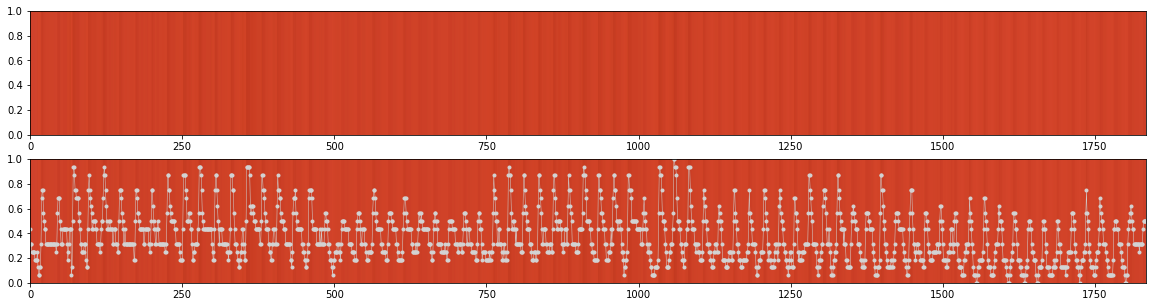

In [150]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,5));
barlist=axes[0].bar(range(movie.shape[0]), 1)
for i in range(movie.shape[0]):
    color = colors.to_rgb(color_array[i]/255)
    barlist[i].set_color(color)

axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, movie.shape[0]])

barlist=axes[1].bar(range(movie.shape[0]), 1)
for i in range(movie.shape[0]):
    color = colors.to_rgb(color_array[i]/255)
    barlist[i].set_color(color)
    

h_array = np.empty([movie.shape[0], 1])
for i in range(movie.shape[0]):
    h_array[i] = 1-colors.rgb_to_hsv(colors.to_rgb(color_array[i]/255))[2]
b = 1.0/(1.0 - np.max(h_array)/np.min(h_array))
a = -b/np.min(h_array)

axes[1].plot(range(movie.shape[0]),a*h_array+b,color='lightgray',linestyle='-',linewidth=0.5,marker='.')
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, movie.shape[0]])
plt.show()

Так как видео длится минуту, то дальнейшие значения не нуждаются в дополнительной обработке.  
Ответы даны в формате __удар в минуту__

### 1
Посчитать количество переходов между значениями

In [165]:
data = np.ravel(np.array(a*h_array+b))
data_ = data>np.mean(data)

In [166]:
ans = (np.logical_not(data_[:-1])&(data_[1:])).sum()
print("Количество переходов/ударов в минуту:", ans)

Количество переходов/ударов в минуту: 95


## 2
Воспользоваться функцией `find_peaks`, и ручками подобрать расстояние между пиковыми значениями

In [167]:
from scipy.signal import find_peaks

In [168]:
peaks_ind = find_peaks(data, distance=15)

In [169]:
print("Ударов в минуту:", len(peaks_ind[0]))

Ударов в минуту: 73


# 3
Попробуем убрать шум данных и провести аналогичные измерения

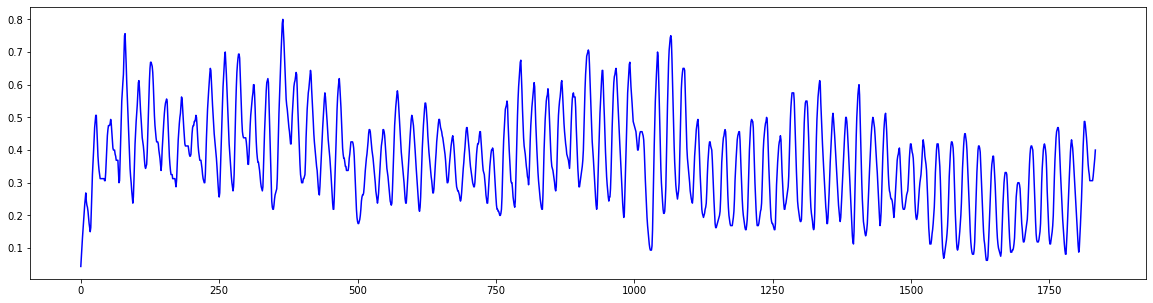

In [170]:
from scipy.signal import lfilter

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))

n = 10  # чем больше n, тем больше сглаживание
b = [1.0 / n] * n
a = 1
smooth_data = lfilter(b,a,data)
axes.plot(
    smooth_data, 
    linestyle="-", 
    c="b"
)

In [177]:
data_ = smooth_data > np.mean(smooth_data)
ans = (np.logical_not(data_[:-1])&(data_[1:])).sum()

In [178]:
print("Количество переходов/ударов в минуту после сглаживания:", ans)

Количество переходов/ударов в минуту после сглаживания: 69


In [179]:
peaks_ind = find_peaks(smooth_data, distance=14)
print("Ударов в минуту:", len(peaks_ind[0]))

Ударов в минуту: 74


Мы получили показатели, значения которых находятся на небольшом расстоянии друг от друга, попробуем усреднить их для получения ответа (первый результят не включим и отбросим его как выброс)

In [182]:
print("Ударов в минуту:", (73+69+74)/3)

Ударов в минуту: 72.0


## Вывод

При попытках очистить данные от лишних кадров значений и подобного мы имеем шанс отбролсить важные данные.
Нам приходится отбрасывать даные изза погрешностей при сборе дынных, которые невозможно избежать в реальных условиях. 
Можно попытаться улучшить датчики, например использовать более высокую частут кадров для записи, или накладывать фильтры в постобработке для лучшего анализа.
Сам спобоб сбора данных при этом является точным и способен предоставить хорошую основу для исследования.
